<a href="https://colab.research.google.com/github/adewale-codes/Machine_learning/blob/main/fake_review_detection_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 #Setup
import os
import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
#Load data
KAGGLE_DEFAULT_PATH = "/content/drive/MyDrive/Review/preReviewsCSV.csv"

DATA_PATH = None

def load_csv():
    global DATA_PATH
    if DATA_PATH and os.path.exists(DATA_PATH):
        return pd.read_csv(DATA_PATH)

    if os.path.exists(KAGGLE_DEFAULT_PATH):
        print(f"Loading Kaggle dataset from: {KAGGLE_DEFAULT_PATH}")
        return pd.read_csv(KAGGLE_DEFAULT_PATH)

    #Colab upload fallback
    try:
        from google.colab import files
        uploaded = files.upload()
        if not uploaded:
            raise FileNotFoundError("No file uploaded.")
        #pick the first uploaded file
        fname = next(iter(uploaded.keys()))
        DATA_PATH = os.path.join("/content", fname)
        print(f"Loaded uploaded file: {DATA_PATH}")
        return pd.read_csv(DATA_PATH)
    except Exception as e:
        raise FileNotFoundError(
            "Could not find the dataset. Set DATA_PATH to your CSV path, "
            "or upload a CSV when prompted (in Colab), or run on Kaggle."
        ) from e

df = load_csv()

print("Shape:", df.shape)
display(df.head())

#Column mapping
text_col = "reviewContent"
flag_col = "flagged"

missing = [c for c in [text_col, flag_col] if c not in df.columns]
if missing:
    raise KeyError(
        f"Missing columns: {missing}. Available columns: {list(df.columns)[:30]}..."
    )

#Create binary label: 1 = fake, 0 = genuine
df["label"] = (df[flag_col].astype(str).str.strip().str.upper() == "Y").astype(int)

# Keep only what we need
df = df[[text_col, "label"]].rename(columns={text_col: "text"}).dropna()
df["text"] = df["text"].astype(str)

print(df["label"].value_counts(dropna=False))


Loading Kaggle dataset from: /content/drive/MyDrive/Review/preReviewsCSV.csv
Shape: (788469, 13)


,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,restaurantID,label,doc_embeddings,Polarity
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,unlik next wed eaten previou night dish comple...,5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA,0,[ 0.683766 0.63532466 0.23880757 -0.292007...,0.9912
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,probabl one best meal ive ever perform food gr...,5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA,0,[ 0.44419715 1.1548862 1.2181414 0.527358...,0.8625
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,servic impecc experi present cool eat balloon ...,3,2,0,0,N,pbEiXam9YJL3neCYHGwLUA,0,[ 0.6349632 0.32095477 1.305077 0.359859...,0.7964
3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,problem place like given exhorbit cost media a...,3,8,0,3,N,pbEiXam9YJL3neCYHGwLUA,0,[ 2.2731347e-01 4.6010903e-01 8.1093842e-01 ...,0.9423
4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,idea write review dine alinea bring whole dif...,5,1,2,0,N,pbEiXam9YJL3neCYHGwLUA,0,[ 0.02975482 0.8131 1.0049679 0.451159...,0.8639


label
0    780140
1      8299
Name: count, dtype: int64


Min/Median/Max chars: 1 327 3856


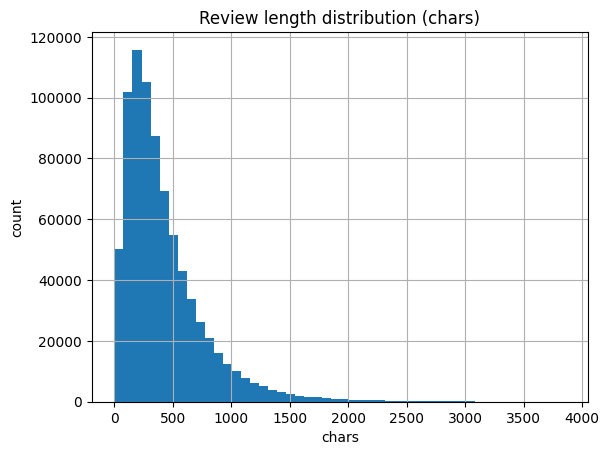

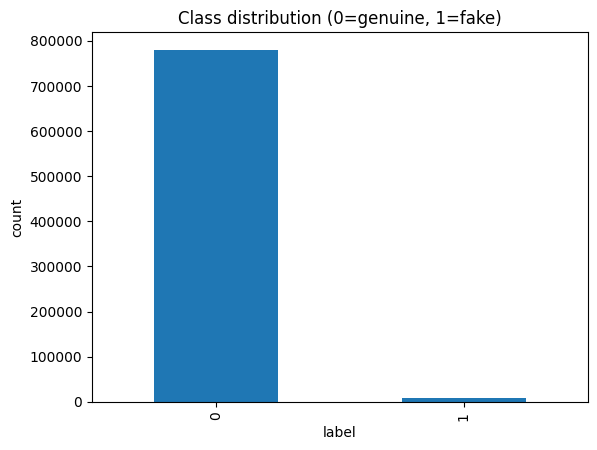

In [4]:
#Basic sanity checks
df["text_len"] = df["text"].str.len()

print("Min/Median/Max chars:", int(df["text_len"].min()), int(df["text_len"].median()), int(df["text_len"].max()))

plt.figure()
df["text_len"].hist(bins=50)
plt.title("Review length distribution (chars)")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()

#Class balance
plt.figure()
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Class distribution (0=genuine, 1=fake)")
plt.xlabel("label")
plt.ylabel("count")
plt.show()


In [5]:
#Split
X = df["text"].values
y = df["label"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", len(X_train), "Val size:", len(X_val))
print("Train label distribution:", np.bincount(y_train))
print("Val label distribution:", np.bincount(y_val))


Train size: 630751 Val size: 157688
Train label distribution: [624112   6639]
Val label distribution: [156028   1660]


In [6]:
#Model pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=None,
        random_state=RANDOM_STATE
    ))
])

pipeline


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

In [7]:
#Train
pipeline.fit(X_train, y_train)
print("Training done.")


Training done.


ROC-AUC: 0.8861

              precision    recall  f1-score   support

  genuine(0)       0.99      0.97      0.98    156028
     fake(1)       0.11      0.38      0.16      1660

    accuracy                           0.96    157688
   macro avg       0.55      0.67      0.57    157688
weighted avg       0.98      0.96      0.97    157688



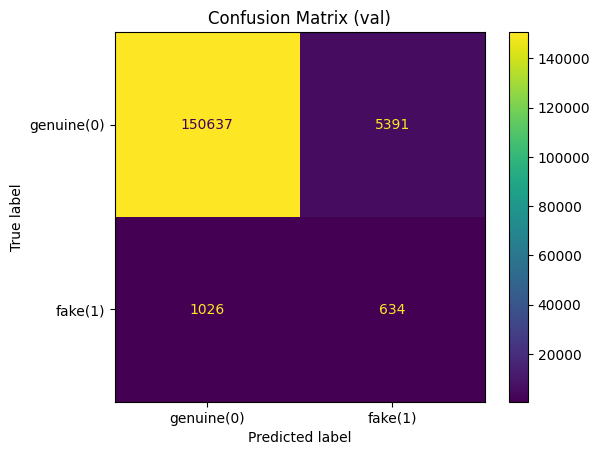

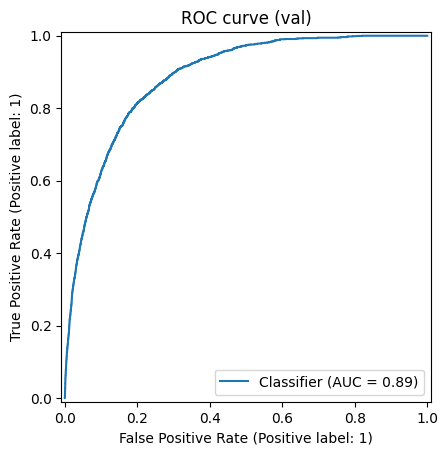

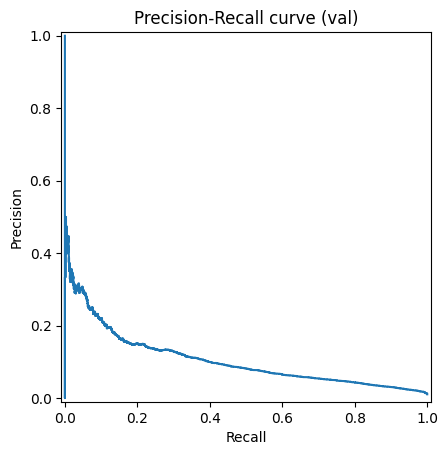

In [8]:
#Evaluate
val_proba = pipeline.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_val, val_proba), 4))
print()
print(classification_report(y_val, val_pred, target_names=["genuine(0)", "fake(1)"]))

cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["genuine(0)", "fake(1)"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (val)")
plt.show()

RocCurveDisplay.from_predictions(y_val, val_proba)
plt.title("ROC curve (val)")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall curve (val)")
plt.show()


In [9]:
#Threshold tuning (optional)
from sklearn.metrics import f1_score

best = {"thr": 0.5, "f1_fake": -1.0}
for thr in np.linspace(0.1, 0.9, 81):
    pred = (val_proba >= thr).astype(int)
    f1_fake = f1_score(y_val, pred, pos_label=1)
    if f1_fake > best["f1_fake"]:
        best = {"thr": float(thr), "f1_fake": float(f1_fake)}

best


{'thr': 0.62, 'f1_fake': 0.18181818181818182}

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Explainability: top terms
tfidf = pipeline.named_steps["tfidf"]
clf = pipeline.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_.ravel()

top_k = 25
top_fake_idx = np.argsort(coefs)[-top_k:][::-1]
top_genuine_idx = np.argsort(coefs)[:top_k]

top_fake = list(zip(feature_names[top_fake_idx], coefs[top_fake_idx]))
top_genuine = list(zip(feature_names[top_genuine_idx], coefs[top_genuine_idx]))

print("Top terms indicating FAKE:")
for term, w in top_fake[:15]:
    print(f"  {term:<20} {w:.4f}")

print("\nTop terms indicating GENUINE:")
for term, w in top_genuine[:15]:
    print(f"  {term:<20} {w:.4f}")


Top terms indicating FAKE:
  thi                  10.8183
  salad bar            10.1359
  nana                 9.0423
  sunda                8.9708
  allianc              8.9388
  garcia               8.8598
  shaw                 8.6010
  calo                 8.3242
  chicago              7.8811
  doug                 7.6546
  bad appl             7.4487
  simpli               7.2910
  opart                7.0953
  yolk                 7.0099
  glenn                6.7817

Top terms indicating GENUINE:
  shop                 -10.2709
  clean                -9.2737
  store                -8.4234
  owner comment        -7.6559
  locat                -7.4040
  view                 -7.3013
  beach                -7.2735
  japanes              -6.8749
  local                -6.8477
  updat                -6.7712
  dr                   -6.6400
  danc                 -6.4761
  compani              -6.4122
  massag               -6.3705
  cute                 -6.2784


In [12]:
#Save model artifact
import joblib

ARTIFACT_PATH = "fake_review_pipeline.joblib"
joblib.dump(pipeline, ARTIFACT_PATH)

print("Saved:", ARTIFACT_PATH)
print("File size (MB):", round(os.path.getsize(ARTIFACT_PATH) / (1024 * 1024), 3))


Saved: fake_review_pipeline.joblib
File size (MB): 98.737


## Quick inference test (single review)

In [13]:
#Inference demo
def predict_review(text: str, threshold: float = 0.5):
    prob_fake = float(pipeline.predict_proba([text])[0, 1])
    label = int(prob_fake >= threshold)
    return {"label": "fake" if label == 1 else "genuine", "prob_fake": prob_fake, "threshold": threshold}

samples = [
    "Absolutely amazing!!! Best product ever, guaranteed results, buy now!!!!",
    "Food was good, service was a bit slow, but I'd still come back."
]

for s in samples:
    print(s)
    print(predict_review(s, threshold=0.5))
    print("-" * 60)


Absolutely amazing!!! Best product ever, guaranteed results, buy now!!!!
{'label': 'genuine', 'prob_fake': 0.054393777001213034, 'threshold': 0.5}
------------------------------------------------------------
Food was good, service was a bit slow, but I'd still come back.
{'label': 'genuine', 'prob_fake': 0.243760946791521, 'threshold': 0.5}
------------------------------------------------------------
